# Sentiment Analysis of Google Reviews for Energy Company

**Goal**

This project focuses on the analysis of Google Reviews written in German for an energy company. The main objective is to understand customer sentiment and extract actionable insights using natural language processing and machine learning techniques.

# **Problem Definition**

The project aims to:

* Perform data cleaning and exploratory data analysis (EDA) on customer review texts
* Preprocess and transform textual data into meaningful features suitable for machine learning models
* Build, train, and compare multiple machine learning models for sentiment classification (positive, negative, neutral)
* Evaluate model performance using appropriate metrics and select the best-performing model
* Interpret the results to derive business insights and understand key drivers of customer sentiment


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from collections import Counter
import nltk
from nltk.corpus import stopwords

# Download stopwords (first time only)
nltk.download('stopwords')

# Set plot style
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (10,5)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [2]:
# Load German stopwords
german_stopwords = set(stopwords.words("german"))

# Optional: extend stopwords with domain-specific words
custom_stopwords = {
    "energie", "strom", "gas", "anbieter", "firma", "unternehmen", "maxenergy"
}

german_stopwords = german_stopwords.union(custom_stopwords)

print(f"Number of stopwords: {len(german_stopwords)}")

Number of stopwords: 239


In [3]:
# Visualization settings
sns.set_theme(style="whitegrid")
plt.rcParams["figure.figsize"] = (12, 6)
plt.rcParams["axes.titlesize"] = 14
plt.rcParams["axes.labelsize"] = 12

In [4]:
list(german_stopwords)[:20]

['andern',
 'jene',
 'einig',
 'euer',
 'anderes',
 'im',
 'hatten',
 'und',
 'musste',
 'dieses',
 'manchen',
 'anderr',
 'den',
 'deines',
 'seine',
 'noch',
 'solcher',
 'mancher',
 'muss',
 'ob']

In [5]:
from google.colab import files
uploaded = files.upload()
INPUT_PATH = list(uploaded.keys())[0]

Saving Google_Reviews_3165.xlsx to Google_Reviews_3165.xlsx


In [6]:
# Load the Excel file into a pandas DataFrame
df = pd.read_excel(INPUT_PATH)

# 1. Basic Data Overview

print("Number of reviews:", len(df))
print("\nColumns in dataset:\n", df.columns.tolist())

print("\nData types:")
print(df.dtypes)

print("\nMissing values per column:")
print(df.isna().sum())

print("\nSample rows:")
display(df.head())

Number of reviews: 3165

Columns in dataset:
 ['Name', 'starRating', 'Komment', 'reviews.createTime', 'Reply Komment', 'reviews.reviewReply.updateTime']

Data types:
Name                                      object
starRating                                object
Komment                                   object
reviews.createTime                datetime64[ns]
Reply Komment                             object
reviews.reviewReply.updateTime    datetime64[ns]
dtype: object

Missing values per column:
Name                                 0
starRating                           0
Komment                            678
reviews.createTime                  30
Reply Komment                     1577
reviews.reviewReply.updateTime    1577
dtype: int64

Sample rows:


,Name,starRating,Komment,reviews.createTime,Reply Komment,reviews.reviewReply.updateTime
0,Karl Frühauf,FIVE,Ich bin mit dem Service sehr zufrieden\n\n(Tra...,2025-06-27 07:34:26.963,NaN,NaT
1,Judith Baum,FIVE,"gutes Preis - Leistungsverhältnis, der Kundend...",2025-06-24 11:21:21.697,"Hallo Judith,\n\nvielen Dank für Deine 5-Stern...",2025-06-25 05:03:26.593
2,Waldemar Scheller,FIVE,NaN,2025-06-23 10:17:47.400,"Hallo Waldemar,\n\nvielen Dank für Deine posit...",2025-06-24 09:55:52.460
3,Matta Botros,FIVE,"preise ok,kunden freundlich,kommen immer entge...",2025-06-16 07:24:37.607,"Hallo Matta,\n\nherzlichen Dank für Deine 5-St...",2025-06-17 06:06:24.280
4,Iris Schneider,THREE,Ab und zu ist der Kundendienst nicht kompetent...,2025-06-09 06:12:36.403,"Hallo Iris,\n\nDanke für Deine Bewertung.\n\nE...",2025-06-10 07:13:36.400


In [7]:
# Step 2: Text Cleaning & Preprocessing


import pandas as pd
import re


# 1️⃣ Drop unnecessary columns safely
# Sometimes columns like "Reply Komment" or "Unnamed" appear from export — remove if they exist
columns_to_drop = [col for col in ["Reply Komment", "reviews.reviewReply.updateTime", "Unnamed: 0"] if col in df.columns]
df = df.drop(columns=columns_to_drop, errors="ignore")

print("Dropped columns (if present):", columns_to_drop)

Dropped columns (if present): ['Reply Komment', 'reviews.reviewReply.updateTime']


In [8]:
# Robust removal of Google translations
import re

def remove_english_translation(text):
    """
    Removes English translations that appear after '(Translated by Google)'
    or similar markers, keeping only the original German part.
    """
    if pd.isna(text):
        return ""

    # Remove everything starting from "(Translated by Google)" (case-insensitive)
    text = re.split(r"\(Translated by Google\)", text, flags=re.IGNORECASE)[0]

    # Remove other possible markers (German export)
    text = re.split(r"\(Übersetzt von Google\)", text, flags=re.IGNORECASE)[0]

    # Remove extra spaces and newlines
    text = text.strip()

    return text

# Apply to your dataset
df["review_clean"] = df["Komment"].astype(str).apply(remove_english_translation)

# Verify
print(df["review_clean"].sample(5, random_state=1).tolist())

['der wechsel funktionierte einfachst und reibungslos, ohne etwas tun zu müssen. erfreulicher geht es nicht!', 'Ein Energie-Dienstleister, der seine Kunden mit Du anschreibt ("Liebe Susi", "Liebe Alexandra") ist lächerlich, überheblich und unprofessionell.', 'Der Wechsel hat wunderbar geklappt. Vielen Dank.', 'Wechsel ging sehr einfach. Leider werden die Netzgebühren nicht mitverrechnet.', 'Alles hat sehr gut und problemlos geklappt']


In [9]:
df.head (5)

,Name,starRating,Komment,reviews.createTime,review_clean
0,Karl Frühauf,FIVE,Ich bin mit dem Service sehr zufrieden\n\n(Tra...,2025-06-27 07:34:26.963,Ich bin mit dem Service sehr zufrieden
1,Judith Baum,FIVE,"gutes Preis - Leistungsverhältnis, der Kundend...",2025-06-24 11:21:21.697,"gutes Preis - Leistungsverhältnis, der Kundend..."
2,Waldemar Scheller,FIVE,NaN,2025-06-23 10:17:47.400,nan
3,Matta Botros,FIVE,"preise ok,kunden freundlich,kommen immer entge...",2025-06-16 07:24:37.607,"preise ok,kunden freundlich,kommen immer entge..."
4,Iris Schneider,THREE,Ab und zu ist der Kundendienst nicht kompetent...,2025-06-09 06:12:36.403,Ab und zu ist der Kundendienst nicht kompetent...


In [10]:
# 3. Basic text normalization

def clean_german_text(text):
    """
    Basic cleaning of German text:
    - Lowercasing
    - Removing URLs, punctuation, numbers, emojis
    - Keeping only alphabetic characters and spaces
    """
    if pd.isna(text):
        return ""

    # Convert to lowercase
    text = text.lower()

    # Remove URLs
    text = re.sub(r"http\S+|www\S+|https\S+", "", text)

    # ! Remove special characters, numbers, punctuation (keep German umlauts)
    text = re.sub(r"[^a-zäöüß\s]", " ", text)

    # Remove extra spaces
    text = re.sub(r"\s+", " ", text).strip()

    return text

# Apply the cleaning function
df["review_clean"] = df["review_clean"].apply(clean_german_text)

In [11]:
print("Number of reviews:", len(df))
print("\nColumns in dataset:\n", df.columns.tolist())

Number of reviews: 3165

Columns in dataset:
 ['Name', 'starRating', 'Komment', 'reviews.createTime', 'review_clean']


In [12]:
# 4. Drop rows with empty or non-German text
df["review_clean"] = df["review_clean"].fillna("").astype(str)

# Remove rows with very short text (likely empty or not meaningful)
df = df[df["review_clean"].str.len() > 10]

# Reset index
df = df.reset_index(drop=True)

print("Text cleaning done. Remaining rows:", len(df))
print("Sample cleaned reviews:")
display(df["review_clean"].head(5))

Text cleaning done. Remaining rows: 2473
Sample cleaned reviews:


,review_clean
0,ich bin mit dem service sehr zufrieden
1,gutes preis leistungsverhältnis der kundendien...
2,preise ok kunden freundlich kommen immer entgegen
3,ab und zu ist der kundendienst nicht kompetent...
4,gutes transparentes unternehmen


In [13]:
df.head(100)

,Name,starRating,Komment,reviews.createTime,review_clean
0,Karl Frühauf,FIVE,Ich bin mit dem Service sehr zufrieden\n\n(Tra...,2025-06-27 07:34:26.963,ich bin mit dem service sehr zufrieden
1,Judith Baum,FIVE,"gutes Preis - Leistungsverhältnis, der Kundend...",2025-06-24 11:21:21.697,gutes preis leistungsverhältnis der kundendien...
2,Matta Botros,FIVE,"preise ok,kunden freundlich,kommen immer entge...",2025-06-16 07:24:37.607,preise ok kunden freundlich kommen immer entgegen
3,Iris Schneider,THREE,Ab und zu ist der Kundendienst nicht kompetent...,2025-06-09 06:12:36.403,ab und zu ist der kundendienst nicht kompetent...
4,Ralf Mader,FIVE,Gutes Transparentes Unternehmen\n\n(Translated...,2025-06-02 11:06:18.280,gutes transparentes unternehmen
...,...,...,...,...,...
95,Peter Smolle,FIVE,Bestes und schnellstes servie mit top preis\nB...,2024-08-24 09:33:04.723,bestes und schnellstes servie mit top preis bi...
96,Katarzyna Mieczkowska,THREE,Anmeldung auf MaxEnergy war unkompliziert dank...,2024-08-22 19:12:58.863,anmeldung auf maxenergy war unkompliziert dank...
97,Kurt Novak,FIVE,Problemloser Wechsel\n\n(Translated by Google)...,2024-08-22 16:07:03.247,problemloser wechsel
98,N. H.,TWO,Wir haben Gas gekündigt und Strom abgeschlosse...,2024-08-22 07:28:56.197,wir haben gas gekündigt und strom abgeschlosse...


/tmp/ipython-input-1149456329.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(


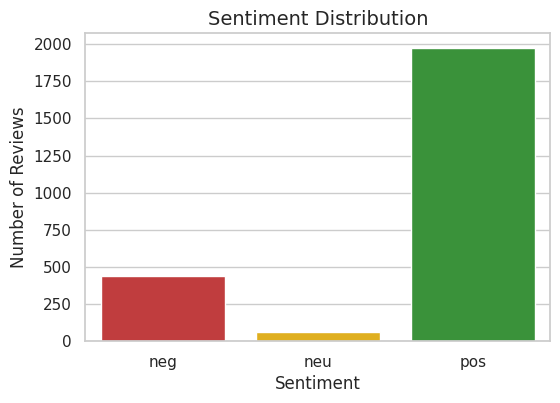

In [14]:
# 5. Map star ratings to sentiment categories
def map_sentiment(rating):
    if rating in ['FIVE', 'FOUR']:
        return 'pos'
    elif rating == 'THREE':
        return 'neu'
    elif rating in ['TWO', 'ONE']:
        return 'neg'
    else:
        return None

df['sentiment'] = df['starRating'].apply(map_sentiment)

# 6. Sentiment Distribution

sentiment_palette = {
    "neg": "#d62728",  # red
    "neu": "#ffbf00",  # yellow
    "pos": "#2ca02c"   # green
}

plt.figure(figsize=(6, 4))
sns.countplot(
    x="sentiment",
    data=df,
    order=["neg", "neu", "pos"],
    palette=sentiment_palette
)

plt.title("Sentiment Distribution")
plt.xlabel("Sentiment")
plt.ylabel("Number of Reviews")
plt.show()


/tmp/ipython-input-1021925524.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="rating_num", data=df, palette="coolwarm")


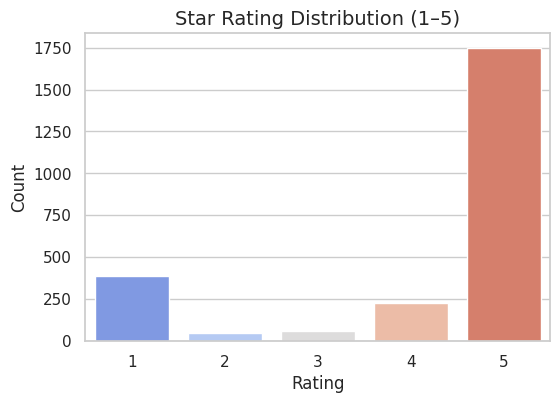

In [15]:
# 7. Star Rating Distribution
# Convert star ratings to numerical format
rating_map = {'ONE': 1, 'TWO': 2, 'THREE': 3, 'FOUR': 4, 'FIVE': 5}
df['rating_num'] = df['starRating'].map(rating_map)

plt.figure(figsize=(6,4))
sns.countplot(x="rating_num", data=df, palette="coolwarm")
plt.title("Star Rating Distribution (1–5)")
plt.xlabel("Rating")
plt.ylabel("Count")
plt.show()

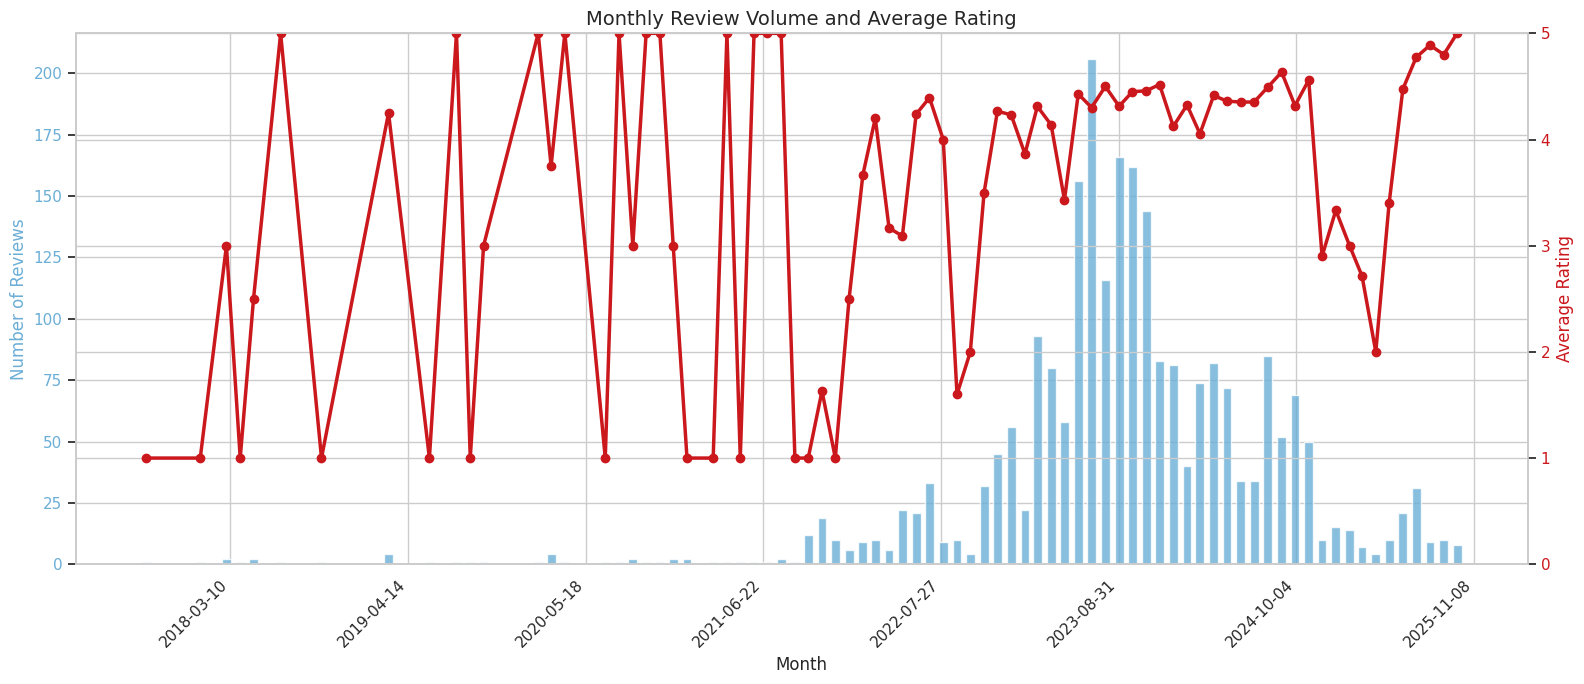

In [16]:
# Step 8

# Ensure datetime format
df["reviews.createTime"] = pd.to_datetime(df["reviews.createTime"])

# Create YearMonth as timestamp (start of month)
df["YearMonth"] = df["reviews.createTime"].dt.to_period("M").dt.to_timestamp()

monthly_stats = (
    df.groupby("YearMonth")
    .agg(
        review_count=("rating_num", "count"),
        avg_rating=("rating_num", "mean")
    )
    .reset_index()
)


fig, ax1 = plt.subplots(figsize=(16, 7))

# Colors
bar_color = "#6BAED6"   # soft blue
line_color = "#CB181D"  # deep red

# Bar chart — number of reviews
ax1.bar(
    monthly_stats["YearMonth"],
    monthly_stats["review_count"],
    width=20,
    color=bar_color,
    alpha=0.8
)
ax1.set_xlabel("Month")
ax1.set_ylabel("Number of Reviews", color=bar_color)
ax1.tick_params(axis="y", labelcolor=bar_color)

# Line chart — average rating
ax2 = ax1.twinx()
ax2.plot(
    monthly_stats["YearMonth"],
    monthly_stats["avg_rating"],
    color=line_color,
    marker="o",
    linewidth=2.5
)
ax2.set_ylabel("Average Rating", color=line_color)
ax2.tick_params(axis="y", labelcolor=line_color)
ax2.set_ylim(0, 5)

# Format x-axis
ax1.xaxis.set_major_locator(plt.MaxNLocator(10))
fig.autofmt_xdate(rotation=45)

# Title
plt.title("Monthly Review Volume and Average Rating")

fig.tight_layout()
plt.show()


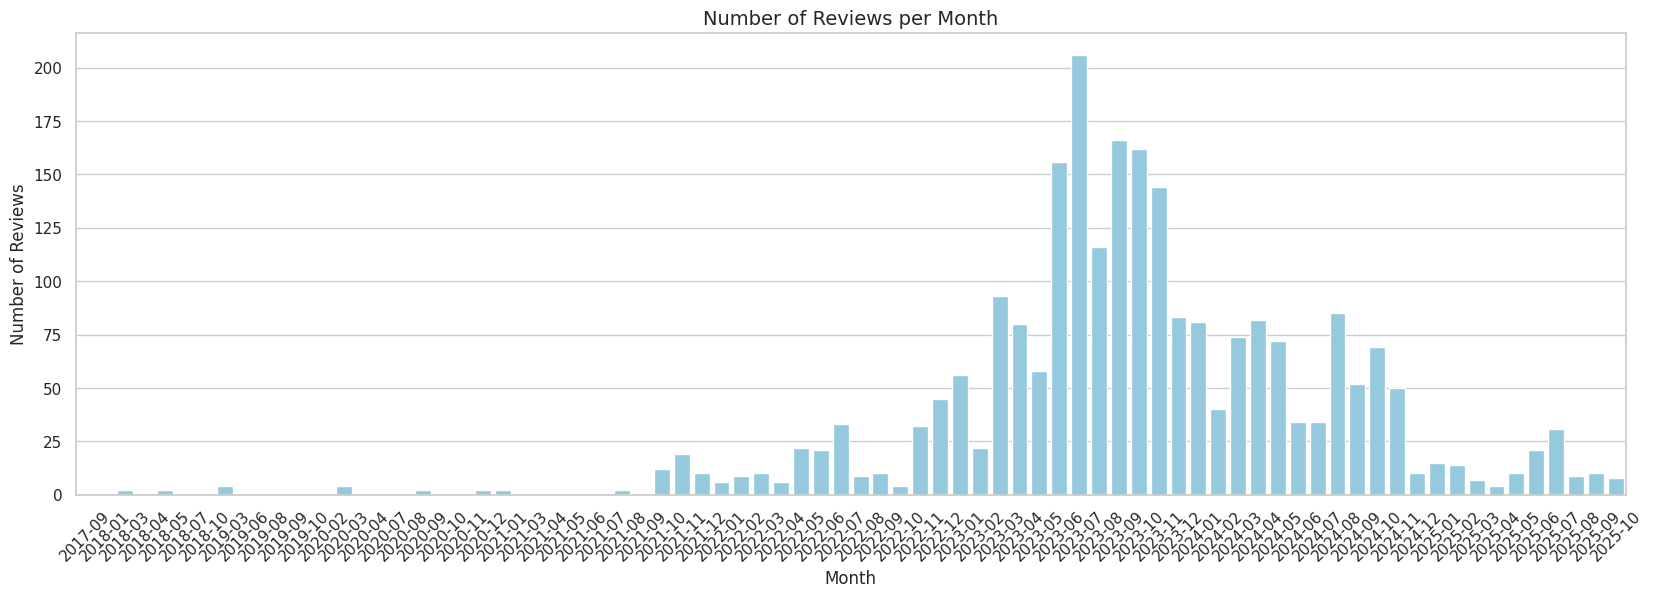

In [17]:
# 9. Number of Reviews per Month
# Handle missing values in 'Komment' before cleaning
df['Komment'] = df['Komment'].fillna('')

import re

# Basic text cleaning function
def clean_text(text):
    text = text.lower()  # Convert to lowercase
    text = re.sub(r'[^a-z0-9\s]', '', text) # Remove punctuation and special characters
    return text

# Apply cleaning to 'Komment' to create 'review_clean'
df['review_clean'] = df['Komment'].apply(clean_text)

# Create 'YearMonth' column if it doesn't exist (assuming 'reviews.createTime' is available)
if 'reviews.createTime' in df.columns:
    df['YearMonth'] = df['reviews.createTime'].dt.to_period('M')
else:
    print("Error: 'reviews.createTime' column not found. Cannot create 'YearMonth'.")


# Now we can proceed with counting reviews per month using 'review_clean'
monthly_count = df.groupby("YearMonth")["review_clean"].count().reset_index()
monthly_count.columns = ["YearMonth", "review_count"]

plt.figure(figsize=(20,6))
sns.barplot(x="YearMonth", y="review_count", data=monthly_count, color="skyblue")
plt.title("Number of Reviews per Month")
plt.xlabel("Month")
plt.ylabel("Number of Reviews")
plt.xticks(rotation=45)
plt.show()

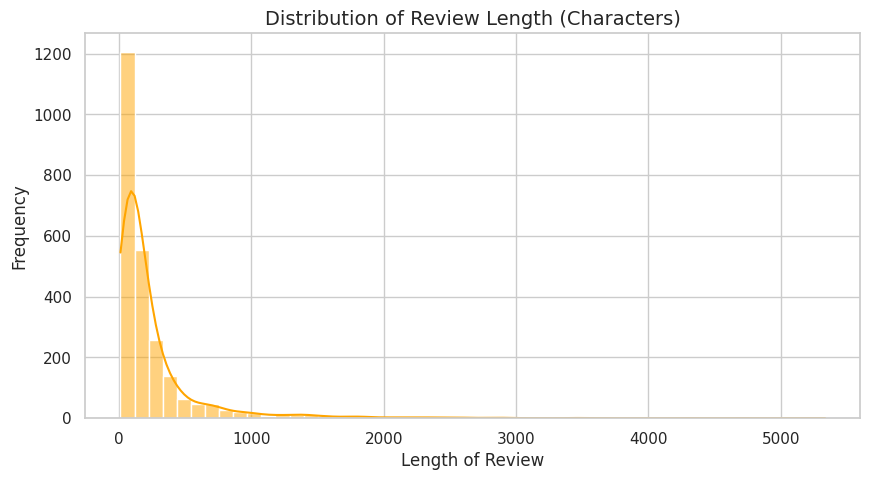


Review Length Statistics:
count    2473.000000
mean      248.400323
std       408.634581
min        11.000000
25%        64.000000
50%       121.000000
75%       252.000000
max      5334.000000
Name: text_len, dtype: float64


In [18]:
# 10. Review Length Analysis

df["text_len"] = df["review_clean"].str.len()
df["word_count"] = df["review_clean"].str.split().apply(len)

plt.figure(figsize=(10,5))
sns.histplot(df["text_len"], bins=50, kde=True, color="orange")
plt.title("Distribution of Review Length (Characters)")
plt.xlabel("Length of Review")
plt.ylabel("Frequency")
plt.show()

print("\nReview Length Statistics:")
print(df["text_len"].describe())

/tmp/ipython-input-966689527.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="sentiment", y="text_len", data=df, order=["neg", "neu", "pos"], palette="Set3")


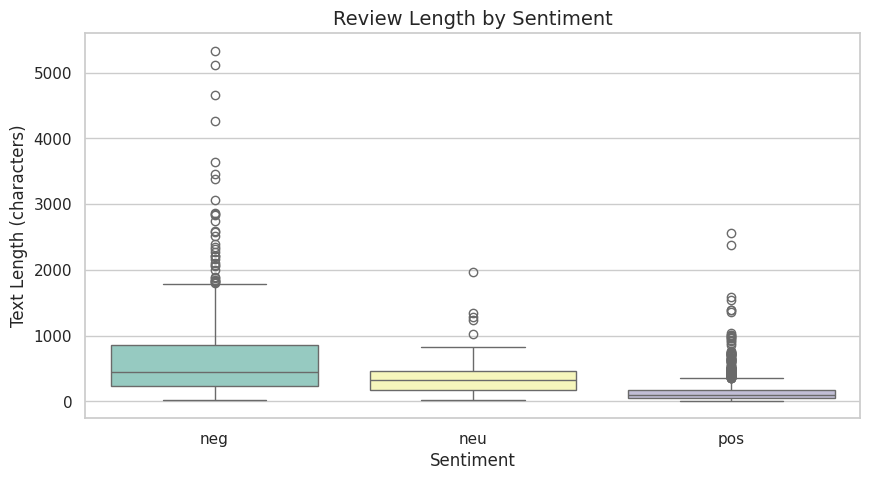

In [19]:
# 11. Review Length by Sentiment

plt.figure(figsize=(10,5))
sns.boxplot(x="sentiment", y="text_len", data=df, order=["neg", "neu", "pos"], palette="Set3")
plt.title("Review Length by Sentiment")
plt.xlabel("Sentiment")
plt.ylabel("Text Length (characters)")
plt.show()

In [20]:
from nltk.corpus import stopwords

# Standard German
stop_words = set(stopwords.words("german")) | set(stopwords.words("english"))
custom_stopwords = {
    "translated", "google", "maxenergy", "energie", "durchblicker", "wien",
    "the", "a", "to", "and", "by", "is", "with", "of", "for", "im", "ich", "uns", "wir", "leider", "unfortunately", "max energy", "und"
}
stop_words = stop_words.union(custom_stopwords)
print(f"Total stopwords: {len(stop_words)}")

Total stopwords: 433


In [21]:
print("Number of reviews:", len(df))
print("\nColumns in dataset:\n", df.columns.tolist())

Number of reviews: 2473

Columns in dataset:
 ['Name', 'starRating', 'Komment', 'reviews.createTime', 'review_clean', 'sentiment', 'rating_num', 'YearMonth', 'text_len', 'word_count']


In [22]:
# 12. Word Frequency per Sentiment

def get_most_common_words(texts, n=15):
    all_words = " ".join(texts).lower().split()
    words = [w for w in all_words if w.isalpha() and w not in stop_words]
    return Counter(words).most_common(n)

for label in ["neg", "neu", "pos"]:
    top_words = get_most_common_words(df[df["sentiment"] == label]["review_clean"])
    print(f"\nTop words for {label.upper()} reviews:")
    print(pd.DataFrame(top_words, columns=["word", "count"]))


Top words for NEG reviews:
        word  count
0      wurde    198
1   contract    139
2    service    134
3      strom    130
4   customer    128
5      email    127
6         fr    127
7        max    118
8    vertrag    117
9     emails    115
10    energy    106
11     price    100
12  anbieter     97
13       gas     97
14     immer     92

Top words for NEU reviews:
             word  count
0         wechsel     28
1           wurde     25
2              fr     19
3   netzbetreiber     18
4           schon     17
5          wochen     16
6           strom     13
7           immer     13
8             gut     12
9   kundenservice     12
10        vertrag     12
11           beim     11
12     abrechnung     11
13            gas     11
14          email     10

Top words for POS reviews:
               word  count
0           wechsel    679
1           einfach    362
2     unkompliziert    359
3           schnell    230
4        problemlos    209
5            change    206
6      

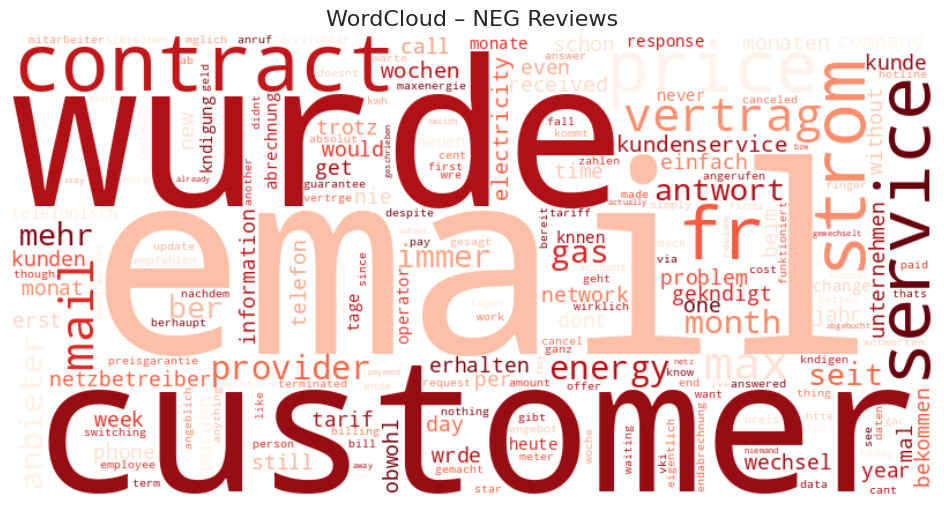

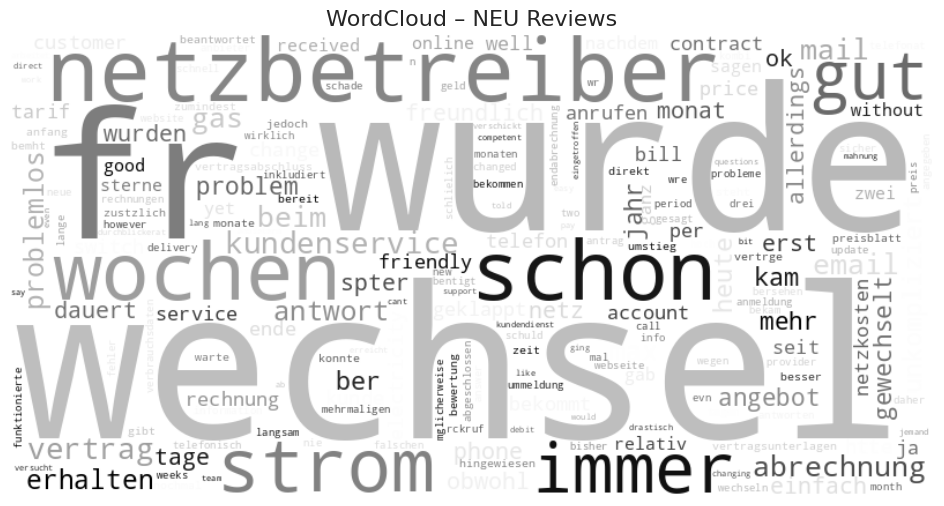

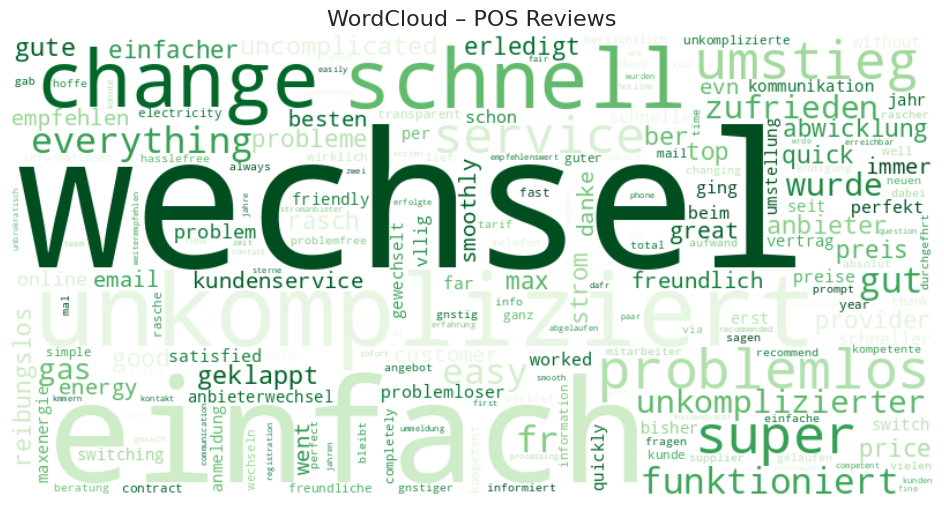

In [23]:
# 13. WordClouds by Sentiment


for label, colormap in zip(
    ["neg", "neu", "pos"],
    ["Reds", "Greys", "Greens"]
):
    text = " ".join(
        df[df["sentiment"] == label]["review_clean"].astype(str)
    )

    wc = WordCloud(
        width=800,
        height=400,
        background_color="white",
        colormap=colormap,
        stopwords=stop_words,
        max_words=200,
        collocations=False
    ).generate(text)

    plt.figure(figsize=(12, 6))
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(f"WordCloud – {label.upper()} Reviews", fontsize=16)
    plt.show()


In [39]:
print("Number of reviews:", len(df))
print("\nColumns in dataset:\n", df.columns.tolist())

Number of reviews: 2473

Columns in dataset:
 ['Name', 'starRating', 'Komment', 'reviews.createTime', 'review_clean', 'sentiment', 'rating_num', 'YearMonth', 'text_len', 'word_count']


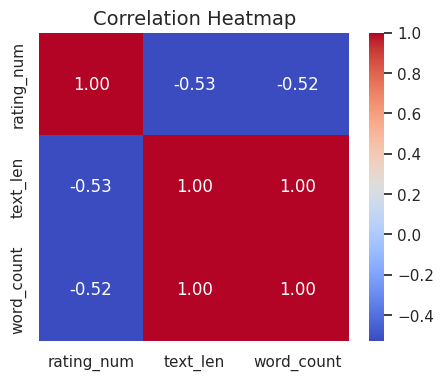

In [24]:
# 14. Correlation (Numeric Features)

num_cols = ["rating_num", "text_len", "word_count"]
corr = df[num_cols].corr()

plt.figure(figsize=(5,4))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()

### Key Insights
- Text length and word count are strongly correlated, indicating feature redundancy.
- Lower ratings are associated with longer and more detailed reviews.
- Review length provides additional signal for sentiment classification.


In [25]:
print("Number of reviews:", len(df))
print("\nColumns in dataset:\n", df.columns.tolist())

Number of reviews: 2473

Columns in dataset:
 ['Name', 'starRating', 'Komment', 'reviews.createTime', 'review_clean', 'sentiment', 'rating_num', 'YearMonth', 'text_len', 'word_count']


## Themen

In [26]:
# 15. Install langdetect if not already installed
!pip install langdetect

from langdetect import detect

def contains_english(text):
    try:
        return detect(text) == "en"
    except:
        return False

english_count = sum(df["review_clean"].apply(contains_english))
print(f"Number of reviews still detected as English: {english_count}")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 11.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for langdetect: filename=langdetect-1.0.9-py3-none-any.whl size=993223 sha256=f262e5ab3e3521ef8b112840b7492d3535ad1d7d51b8c72ddb6968ca0ac5720d
  Stored in directory: /root/.cache/pip/wheels/c1/67/88/e844b5b022812e15a52e4eaa38a1e709e99f06f6639d7e3ba7
Successfully built langdetect
Number of reviews still detected as English: 937


In [27]:
from sklearn.feature_extraction.text import CountVectorizer

def get_top_ngrams(texts, ngram_range=(2,3), n=15, stop_words=None):
    """
    Extract top n-grams from a list of texts.
    """
    vectorizer = CountVectorizer(ngram_range=ngram_range, stop_words=stop_words)
    X = vectorizer.fit_transform(texts)
    sums = X.sum(axis=0)
    data = [(word, sums[0, idx]) for word, idx in vectorizer.vocabulary_.items()]
    data = sorted(data, key=lambda x: x[1], reverse=True)
    return data[:n]

# Example for positive reviews
pos_texts = df[df["sentiment"]=="pos"]["review_clean"]
neg_texts = df[df["sentiment"]=="neg"]["review_clean"]

# Define stop words (same as before)
stop_words_custom = list(stop_words)  # Convert set to list

# Top 15 bigrams/trigrams for positive
top_pos_phrases = get_top_ngrams(pos_texts, ngram_range=(2,3), n=15, stop_words=stop_words_custom)
print("Top phrases in POS reviews:")
print(pd.DataFrame(top_pos_phrases, columns=["phrase","count"]))

# Top 15 bigrams/trigrams for negative
top_neg_phrases = get_top_ngrams(neg_texts, ngram_range=(2,3), n=15, stop_words=stop_words_custom)
print("\nTop phrases in NEG reviews:")
print(pd.DataFrame(top_neg_phrases, columns=["phrase","count"]))

/usr/local/lib/python3.12/dist-packages/sklearn/feature_extraction/text.py:402: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['energy', 'max'] not in stop_words.
  warnings.warn(


Top phrases in POS reviews:
                     phrase  count
0   unkomplizierter wechsel     99
1     einfach unkompliziert     68
2           wechsel einfach     52
3                max energy     51
4     schnell unkompliziert     50
5             went smoothly     42
6      problemloser wechsel     35
7          customer service     34
8         einfacher wechsel     34
9     wechsel unkompliziert     32
10        everything worked     30
11       wechsel problemlos     30
12         without problems     28
13          einfach schnell     26
14                 per mail     26


/usr/local/lib/python3.12/dist-packages/sklearn/feature_extraction/text.py:402: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['energy', 'max'] not in stop_words.
  warnings.warn(



Top phrases in NEG reviews:
                phrase  count
0           max energy     71
1     customer service     60
2      price guarantee     29
3     network operator     25
4            strom gas     22
5             per mail     21
6          even though     20
7          seit wochen     17
8      switching bonus     16
9            stay away     13
10    vertrag gekndigt     11
11      neuen anbieter     11
12  beim netzbetreiber     11
13          12 monaten     11
14     emails answered     10


In [42]:
# 16. Save cleaned dataframe to CSV for future use
df.to_csv("google_reviews_cleaned.csv", index=False)
print("Cleaned dataset saved as 'google_reviews_cleaned.csv'")

Cleaned dataset saved as 'google_reviews_cleaned.csv'
